Understanding the distinct roles these models play is key to harnessing their potential:

BERT excels in tasks such as sentiment analysis, question answering, and named entity recognition, where word-level granularity is crucial.
Sentence Transformers are the preferred choice for semantic similarity assessments, text matching, and document retrieval tasks, where capturing the essence of entire sentences or paragraphs is essential.

In [ ]:
%pip install sentence-transformers
%pip install transformers
%pip install datasets
%pip install faiss
%pip install torch

In [78]:
import pandas as pd
import re
import nltk
from datasets import load_dataset

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer, AutoModel

from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

from sentence_transformers import SentenceTransformer, LoggingHandler, losses, models, util
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader
import logging
import torch
from sentence_transformers import InputExample
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
import os
from IPython.display import Image
import matplotlib.image as mpimg

In [ ]:
dataset = load_dataset("talanAI/resumesamples")
dataset = pd.DataFrame(dataset['train'])
dataset = dataset.dropna()
dataset = dataset[:500]

In [69]:
# multi-qa-mpnet-base-dot-v1  <= best quality
# all-mpnet-base-v2 	
# multi-qa-distilbert-cos-v1 	
# multi-qa-MiniLM-L6-cos-v1 <= faster

# Load a pre-trained transformer model
model_names = ['multi-qa-mpnet-base-dot-v1', 'all-mpnet-base-v2', 'multi-qa-distilbert-cos-v1', 'multi-qa-MiniLM-L6-cos-v1']
word_embedding_model = models.Transformer(f"sentence-transformers/{model_names[1]}")

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [62]:
resume_embeddings = model.encode(dataset['Resume'].tolist(), convert_to_tensor=True)
euclidean_distances = torch.pdist(resume_embeddings, p=2).cpu()
euclidean_distances = squareform(euclidean_distances.numpy())

In [63]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(euclidean_distances)
xs, ys = pos[:, 0], pos[:, 1]

/home/vip/victor.henrique/.local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [64]:
# apply k-means clustering based on datapoints defined in xs and ys
kmeans = KMeans(n_clusters=5, random_state=0).fit(pos)
clusters = kmeans.labels_.tolist()
kmeans_error = kmeans.inertia_

/home/vip/victor.henrique/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/tmp/ipykernel_2654/1843450154.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20b', len(set(categories)))


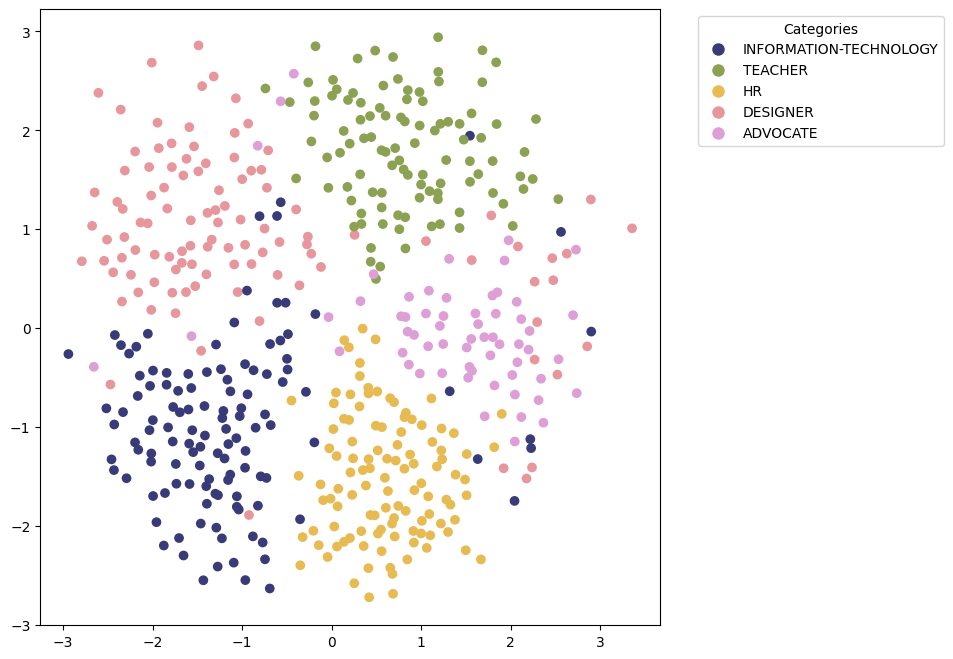

In [67]:
plt.figure(figsize=(8, 8))

# Assuming categories is a list/array of 'category' column
categories = dataset['Category'].tolist()

# Map categories to integers
category_dict = {category: i for i, category in enumerate(set(categories))}
categories = [category_dict[cat] for cat in categories]

# Create a colormap for categories
colormap = plt.cm.get_cmap('tab20b', len(set(categories)))

# Plot the scatter plot with colors based on categories
scatter = plt.scatter(xs, ys, c=categories, cmap=colormap)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(category_dict[category]/len(set(categories))), markersize=10) for category in category_dict]
plt.legend(handles, category_dict.keys(), title="Categories", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.show()


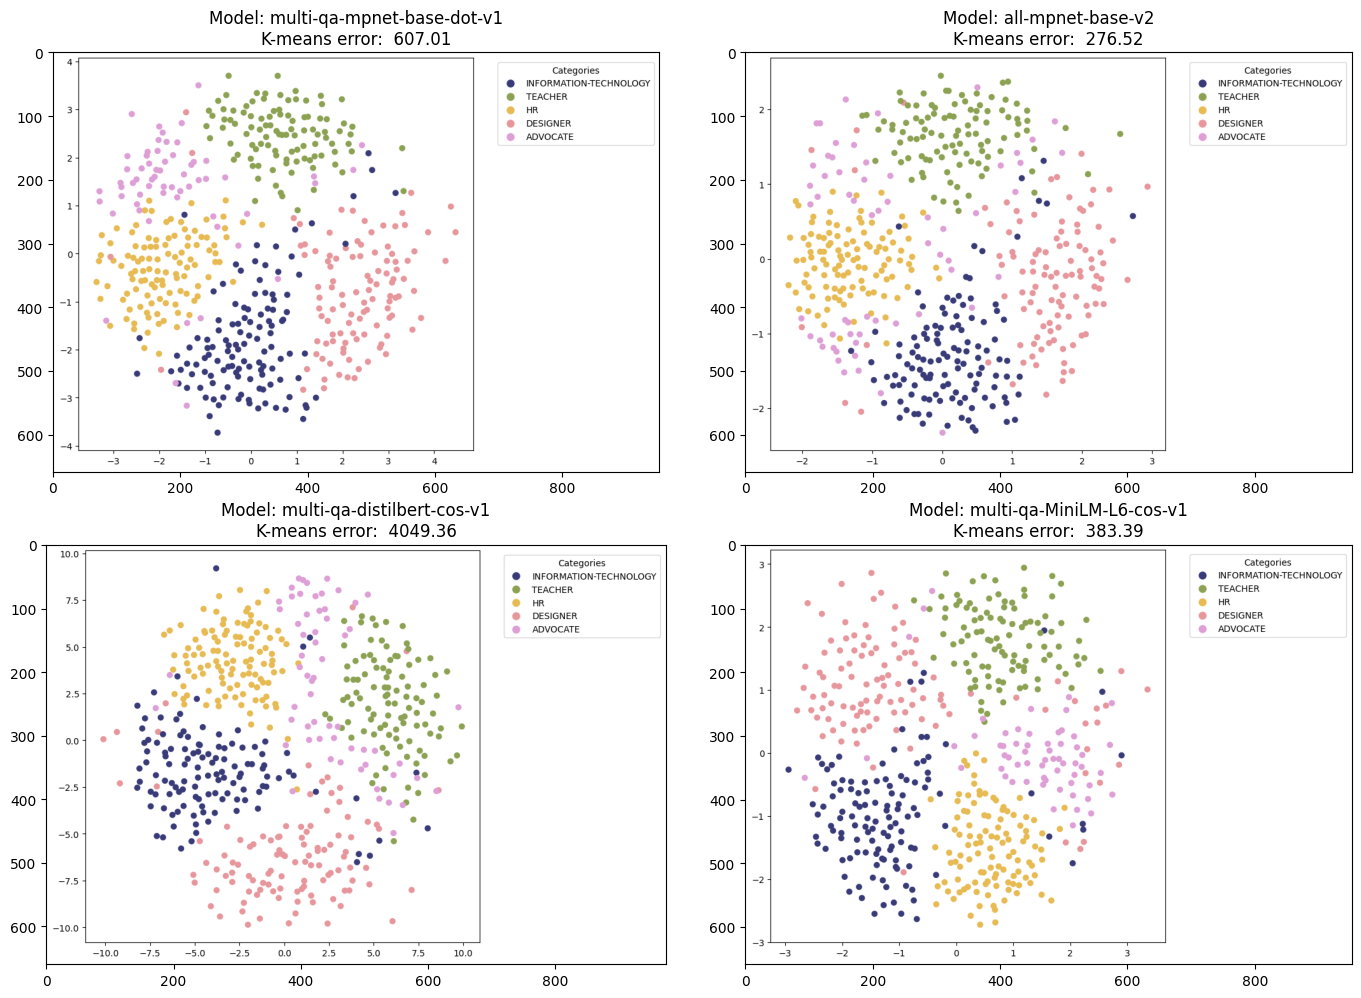

In [83]:
# create a plot with all the 4 images, the plot should have 2 rows and 2 columns each image should have a title with the model name and the k-means error


fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, ax in enumerate(axs.flat):
    with open(f'{model_names[i]}/error.txt', 'r') as f:
        current_kmeans_error = f"{float(f.read()): .2f}"

    img = mpimg.imread(f'{model_names[i]}/plot.png')
    ax.imshow(img)
    ax.set_title(f'Model: {model_names[i]}\nK-means error: {current_kmeans_error}')

plt.tight_layout()
plt.show()